# 3DMNN
#### EXPERIMENTS

In [1]:
import os.path as osp
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.append("/home/viktorv/Projects/3DMNN/main/models/latent_space/src")

from classes.autoencoder import Configuration as Conf
from classes.gan import ConfigurationGAN as ConfGAN
from classes.pointnet_ae import PointNetAutoEncoder

from utils.templates import innofair_architecture
from utils.templates import autoencoder_paper, default_train_params
from utils.io import obj_wrapper

from utils.io import snc_category_to_synth_id, create_dir, PointCloudDataSet, \
                                        load_all_point_clouds_under_folder

from utils.utils import reset_tf_graph
from classes.latent_gan import LatentGAN

top_out_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data'          # Use to save Neural-Net check-points etc.
top_in_dir = '/home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/shape_net_core_uniform_samples_2048/' # Top-dir of where point-clouds are stored.

experiment_name = 'single_class_ae'
n_pc_points = 2048                # Number of points per model.
bneck_size = 128                  # Bottleneck-AE size
ae_loss = 'emd'                   # Loss to optimize: 'emd' or 'chamfer'

class_name = input('Give me the class name (e.g. "chair"): ').lower()

syn_id = snc_category_to_synth_id()[class_name]
class_dir = osp.join(top_in_dir, syn_id)

all_pc_data = load_all_point_clouds_under_folder(class_dir, n_threads=8, file_ending='.ply', verbose=True)

# train_params = default_train_params()

# encoder, decoder, enc_args, dec_args = autoencoder_paper(n_pc_points, bneck_size)
train_dir = create_dir(osp.join(top_out_dir, experiment_name))

# conf = Conf(
#     n_input = [n_pc_points, 3],
#     loss = ae_loss,
#     training_epochs = 50,
#     batch_size = train_params['batch_size'],
#     denoising = train_params['denoising'],
#     learning_rate = train_params['learning_rate'],
#     train_dir = train_dir,
#     loss_display_step = train_params['loss_display_step'],
#     saver_step = train_params['saver_step'],
#     z_rotate = train_params['z_rotate'],
#     encoder = encoder,
#     decoder = decoder,
#     encoder_args = enc_args,
#     decoder_args = dec_args
# )
# conf.experiment_name = experiment_name
# conf.held_out_step = 5   # How often to evaluate/print out loss on 
#                          # held_out data (if they are provided in ae.train() ).
# conf.save(osp.join(train_dir, 'configuration'))


# ae = PointNetAutoEncoder(conf.experiment_name, conf)

# buf_size = 1 # Make 'training_stats' file to flush each output line regarding training.
# fout = open(osp.join(conf.train_dir, 'train_stats.txt'), 'a', buf_size)
# train_stats = ae.train(all_pc_data, conf, log_file=fout)
# fout.close()

conf = Conf.load(train_dir + "/configuration")
conf.encoder_args['verbose'] = False
conf.decoder_args['verbose'] = False

reset_tf_graph()
ae = PointNetAutoEncoder(conf.experiment_name, conf)
ae.restore_model(conf.train_dir, 50, verbose=True)


Give me the class name (e.g. "chair"): airplane
<generator object files_in_subdirs at 0x7f677d2e73b8>
4045 pclouds were loaded. They belong in 1 shape-classes.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
INFO:tensorflow:Restoring parameters from /home/viktorv/Projects/3DMNN/data/point_cloud_sampled/data/single_class_ae/models.ckpt-50
Model restored in epoch 50.


Trained a simple point net auto encoder... Define reconstruct and interpolate functions

In [2]:
#reconstructions = np.asarray(ae.reconstruct(feed_pc))
latent_codes = ae.get_latent_codes(all_pc_data.point_clouds)

def reconstruct_obj(reconstructions):
    print("Reconstruction item shape:", reconstructions[0].shape)
    
    for i, reconstruction in enumerate(reconstructions):
        obj_wrapper(reconstruction, class_name, i)
        
    print("Reconstructed")

def interpolate(_from, _to, steps=10):
    
    print("Generating interpolations")
    interpolations = ae.interpolate(reconstructions[0][_from], reconstructions[0][_to], steps)

    for i, interpolation in enumerate(interpolations):
        obj_wrapper(interpolation, class_name + "_intr", i)

    print("Interpolation Complete")
    print(interpolations.shape)

Create and Configure GAN...

In [3]:
generator, discriminator, params = innofair_architecture(128)

print(latent_codes.shape)
print(params)
# TODO:
# 5. Implement Conditional GAN in the LGAN

reset_tf_graph()
gan = LatentGAN(experiment_name, params['init_lr'], params['lambda'], params['n_out'],\
                params['noise_dim'], discriminator, generator, beta=params['beta'])


(4045, 128)
{'init_lr': 0.0001, 'lambda': 10, 'n_out': [128], 'noise_dim': 128, 'beta': 0.5, 'batch_size': 50, 'noise_params': {'mu': 0, 'sigma': 0.2}}
Calculating initial GP...


1 (-10.466267962753772, -1.3301508002914488)
INFO:tensorflow:./models_checkpoints/models.ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
2 (-20.033475279808044, -4.909787803888321)
3 (-19.440230679512023, -6.018309324979782)
4 (-18.45305371284485, -6.690662205219269)
5 (-17.394561886787415, -7.378544270992279)
INFO:tensorflow:./models_checkpoints/models.ckpt-5 is not in all_model_checkpoint_paths. Manually adding it.
6 (-16.29104107618332, -8.011303454637527)
7 (-15.165653610229493, -8.536432921886444)
8 (-14.032178139686584, -8.968169271945953)
9 (-12.932712888717651, -9.298060417175293)
10 (-11.866479182243348, -9.45696747303009)
INFO:tensorflow:./models_checkpoints/models.ckpt-10 is not in all_model_checkpoint_paths. Manually adding it.
11 (-10.892552840709687, -9.441018402576447)
12 (-9.983366239070893, -9.239046573638916)
13 (-9.186251533031463, -8.906524538993835)
14 (-8.455861842632293, -8.424207270145416)
15 (-7.81266176700592, -7.785468101501465)
16 (-7.268777

169 (-1.405668778717518, -0.2534406131017022)
170 (-1.4045718282461166, -0.37536528520286083)
171 (-1.4151836559176445, -0.42226624116301537)
172 (-1.4319659754633904, -0.12353390097268857)
173 (-1.438721239566803, -0.3645202135667205)
174 (-1.4379977524280547, -0.23362238821573555)
175 (-1.4551651269197463, -0.38532136008143425)
176 (-1.468047198653221, -0.35696297651156783)
177 (-1.481370984017849, -0.46536322589963675)
178 (-1.4894889369606972, -0.37280905339866877)
179 (-1.480604414641857, -0.3708619335666299)
180 (-1.5224449038505554, -0.29380722157657146)
181 (-1.515509693324566, -0.29033239744603634)
182 (-1.5201888054609298, -0.44344861805438995)
183 (-1.5103881165385247, -0.5195136684924364)
184 (-1.5111168429255486, -0.4363912045955658)
185 (-1.5275006309151649, -0.2412764320615679)
186 (-1.535043515264988, -0.3972593666985631)
187 (-1.512835331261158, -0.4115396421402693)
188 (-1.539988322556019, -0.5663268622010946)
189 (-1.523150311410427, -0.7003116086125374)
190 (-1.5545

341 (-1.504961259663105, 1.202447209507227)
342 (-1.4973988443613053, 1.2089039534330368)
343 (-1.5086744248867034, 1.164729744195938)
344 (-1.502523910999298, 1.1312818378210068)
345 (-1.5014034926891326, 1.222230151295662)
346 (-1.4859117552638055, 1.2033747360110283)
347 (-1.504481066763401, 1.2380829602479935)
348 (-1.4979457810521126, 1.1653413698077202)
349 (-1.514356130361557, 1.1698792949318886)
350 (-1.495911617577076, 1.147412795573473)
INFO:tensorflow:./models_checkpoints/models.ckpt-350 is not in all_model_checkpoint_paths. Manually adding it.
351 (-1.5191452130675316, 1.1192518584430218)
352 (-1.5039336860179902, 1.0897531881928444)
353 (-1.5073440581560136, 1.2036613263189793)
354 (-1.5021792635321618, 1.0641833767294884)
355 (-1.4979552909731866, 1.1189502589404583)
356 (-1.49652801156044, 1.1358990222215652)
357 (-1.5060093954205513, 1.1545468382537365)
358 (-1.490921686589718, 1.1439301520586014)
359 (-1.504642342031002, 1.1259208358824253)
360 (-1.500357384979725, 1.0

512 (-1.3391264006495476, 0.7449744045734406)
513 (-1.365948374569416, 0.840736385434866)
514 (-1.366862305998802, 0.8721480593085289)
515 (-1.3509281620383262, 0.8007576167583466)
516 (-1.3472978085279466, 0.8890481069684029)
517 (-1.3479040563106537, 0.9008056782186031)
518 (-1.35593671053648, 0.8520814031362534)
519 (-1.3513332657516002, 0.8548678457736969)
520 (-1.3577119037508965, 0.8693292774260044)
521 (-1.341520433872938, 0.850979920476675)
522 (-1.3511890321969986, 0.8036865592002869)
523 (-1.3411009356379509, 0.7552418857812881)
524 (-1.3299707740545272, 0.8362632095813751)
525 (-1.3475401476025581, 0.8175021447241306)
526 (-1.3746430680155755, 0.842773012816906)
527 (-1.3538155153393745, 0.838016003370285)
528 (-1.347774888575077, 0.88160664960742)
529 (-1.357759565114975, 0.874647993594408)
530 (-1.3518937200307846, 0.8574583120644093)
531 (-1.353262197971344, 0.8785846643149853)
532 (-1.3062109142541884, 0.8926180601119995)
533 (-1.3606198251247406, 0.8747285306453705)
534

684 (-1.2577409483492374, 0.48063696548342705)
685 (-1.255413828790188, 0.399172930046916)
686 (-1.2505129635334016, 0.38411496859043837)
687 (-1.2552620127797127, 0.4616741444915533)
688 (-1.2605692610144614, 0.39241308718919754)
689 (-1.2563358016312123, 0.4844644982367754)
690 (-1.2519824340939523, 0.4118434302508831)
691 (-1.2640829510986804, 0.41800892539322376)
692 (-1.2628657132387162, 0.4443672727793455)
693 (-1.2482747867703439, 0.4868819862604141)
694 (-1.2397740758955478, 0.44248212687671185)
695 (-1.260473546385765, 0.38229506835341454)
696 (-1.273601410537958, 0.4773601368069649)
697 (-1.2532839730381966, 0.44152423180639744)
698 (-1.2409624248743056, 0.4818610828369856)
699 (-1.2468143686652184, 0.43725385144352913)
700 (-1.2491052970290184, 0.4410137664526701)
INFO:tensorflow:./models_checkpoints/models.ckpt-700 is not in all_model_checkpoint_paths. Manually adding it.
701 (-1.2500306822359561, 0.43200888857245445)
702 (-1.2314343333244324, 0.45543309673666954)
703 (-1.2

853 (-1.1908701658248901, 0.3532456289976835)
854 (-1.2015157096087932, 0.3789222417399287)
855 (-1.187764037400484, 0.3930857218801975)
856 (-1.1993667609989642, 0.381752023473382)
857 (-1.1830619893968106, 0.4081887789070606)
858 (-1.2057399228215218, 0.35096481069922447)
859 (-1.203111431747675, 0.3648823192343116)
860 (-1.1916808597743511, 0.36476342007517815)
861 (-1.189085315912962, 0.325263659004122)
862 (-1.1918684989213943, 0.2955026626586914)
863 (-1.190319299697876, 0.2722598840482533)
864 (-1.1988029047846793, 0.32068108301609755)
865 (-1.198226235806942, 0.32681983802467585)
866 (-1.18531209602952, 0.3639382952824235)
867 (-1.1927217274904252, 0.32192178908735514)
868 (-1.2043923646211625, 0.35087723564356565)
869 (-1.183279351145029, 0.34431050065904856)
870 (-1.187426468729973, 0.34841412864625454)
871 (-1.195792406052351, 0.3304504291154444)
872 (-1.1851643316447735, 0.3679442349821329)
873 (-1.1735669441521168, 0.36823565792292356)
874 (-1.202513712644577, 0.3868719153

/home/viktorv/.conda/envs/3dmnn_cu9/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


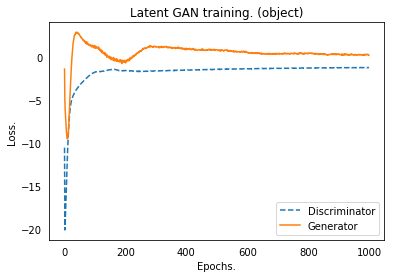

In [4]:
accum_syn_data = []
train_stats = []
n_epochs = 1000
# Train the GAN.
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(50, n_epochs + 1, 50)])
latent_data = PointCloudDataSet(latent_codes)

gan.train(latent_data, params, n_epochs, "./models_checkpoints/", save_gan_model=True, \
          saver_step=saver_step, train_stats=train_stats)

In [5]:
syn_latent_data = gan.generate(5, params["noise_params"])
syn_data = ae.decode(syn_latent_data)
print(syn_data.shape)

reconstruct_obj(syn_data)

(5, 2048, 3)
Reconstruction item shape: (2048, 3)
Reconstructed


# TODO
### 1. Rewrite CONF Class to fit GANs - DONE
### 2. Implement Discriminator, Generator for the simple LGAN - DONE
### 3. Train
### 4. Try to decode something generated
### 5. Implement Conditional GAN in the LGAN 
### 6. Go to 3 and 4 again